In [181]:
import pandas as pd
import numpy as np
from numpy.linalg import solve
import base64
import math

from skimage.filters import gaussian_filter, scharr_h, scharr_v
from skimage.feature import peak_local_max
from skimage.transform import resize, rotate
import skimage.color
import skimage.io

import scipy.misc
from scipy.signal import convolve

import itertools
from itertools import tee, islice
import imageio

from IPython.display import HTML

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from more_itertools import pairwise
sns.set(color_codes=True)

/usr/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [150]:
def get_sigma(scale):
    if scale == 0:
        return (np.sqrt(2)) # *(octave+1)
    else:
        return get_sigma(scale-1)*np.sqrt(2)

def dog_pyramid_octave(im, octave, nb_scales=5):
    gaussians = []
    for s in range(nb_scales):
        sigma = get_sigma(s)
        print("{:.4f}   ".format(sigma), end='')
        g = gaussian_filter(im, sigma, mode='mirror')
        gaussians.append(g)
    print()
    return np.stack([g1 - g0 for g0, g1 in pairwise(gaussians)]), np.stack(gaussians)

def dog_pyramid(im, nb_octaves=3, nb_layers=5):
    prev = im
    dogs = []
    for i in range(nb_octaves):
        dog, gaussians = dog_pyramid_octave(prev, i, nb_layers)
        prev = gaussians[-1, ::2, ::2]
        dogs.append(dog)
    return dogs

In [151]:
def load_lena():
    lena = scipy.misc.lena() / 255
    return resize(lena, np.array(lena.shape)*2)

1.4142   2.0000   2.8284   4.0000   5.6569   


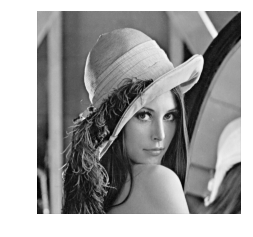

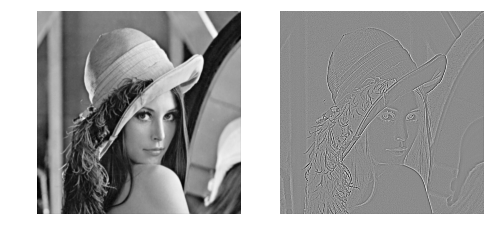

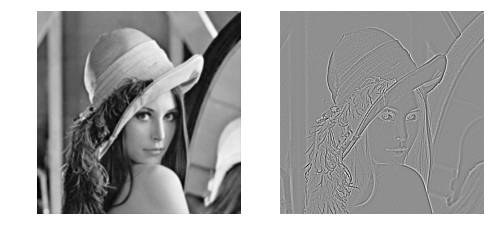

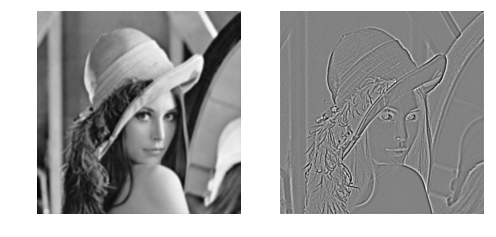

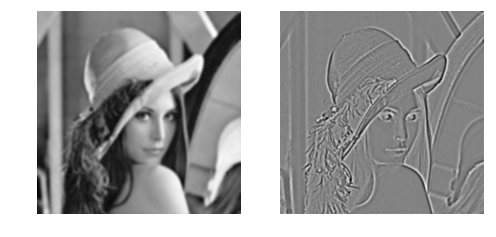

In [152]:
lena = load_lena()
dog, gs = dog_pyramid_octave(lena, 0)

for i, g in enumerate(gs):
    plt.subplot(121)
    plt.imshow(g, cmap='gray')
    plt.axis('off')
    if i >= 1:
        plt.subplot(122)
        plt.imshow(dog[i-1], cmap='gray')
        plt.axis('off')
    plt.show()

In [153]:
def get_partial_derivative(tensor, i):
    derivf = np.array([-1, 0, 1])
    derivf = derivf / np.sum(np.abs(derivf))
    return convolve(tensor, derivf.reshape(np.roll([1, 1, 3], i)), mode='same')

def get_derivatives(dogs):
    # partial derivatives of sigma, y and x
    derivs = np.array([get_partial_derivative(dogs, i) for i in range(3)])
    
    H = np.zeros((3, 3, *dogs.shape))
    for indices in itertools.product(range(3), repeat=2):
        d0 = derivs[indices[0]]
        H[indices[0], indices[1]] = get_partial_derivative(d0, indices[1])
        
    return H, derivs

class SIFT:
    def __init__(self, image, num_octaves=4):
        self.image = image
        self.num_octaves = num_octaves
        
        self.scaled_images = [self.image]
        self.dog_pyramid = []
        self.gaussian_pyramid = []
        self.hessians = []
        self.partial_derivatives = []
        self._build_dogs()
        self._build_derivatives()
        
    def _build_dogs(self):
        assert len(self.dog_pyramid) == 0
        for i in range(self.num_octaves):
            dogs, gs = dog_pyramid_octave(self.scaled_images[i], i)
            self.dog_pyramid.append(dogs)
            self.gaussian_pyramid.append(gs)
            if i < self.num_octaves - 1:
                self.scaled_images.append(gs[2, ::2, ::2])
        
    def _build_derivatives(self):
        assert len(self.hessians) == 0
        for dogs in self.dog_pyramid:
            H, d = get_derivatives(dogs)
            self.hessians.append(H)
            self.partial_derivatives.append(d)
            
    def get_inital_keypoints(self):
        def extrema(dogs):
            return np.concatenate([peak_local_max(dogs, min_distance=1, threshold_rel=0.), 
                                   peak_local_max(-dogs, min_distance=1, threshold_rel=0.)])
        
        return [extrema(dogs) for dogs in self.dog_pyramid]
    
    def get_accurate_keypoints(self, extrema, pyramid_level, finalized_extrema=None, num_iteration=0):
        def shift(e, offset):
            return np.round(e + offset).astype('int')

        def in_bounds(p):
            try:
                H[:, :, p[0], p[1], p[2]]
                return True
            except IndexError:
                return False

        def has_sufficent_constrast(point, offset, threshold=0.03):
            p = point
            D = dogs[tuple(point)]
            d = derivs[:, p[0], p[1], p[2]]
            contrast = D + 0.5 * d.T @ offset
            return np.abs(contrast) > threshold

        def is_extrema(point, offset, max_iterations=20):
            shift_point = shift(point, offset) 
            return (num_iteration >= max_iterations or \
                np.all(shift_point == point) or \
                np.min(shift_point) < 0) and \
                in_bounds(shift_point)               

        def get_taylor_offset(p):
            h = H[:, :, p[0], p[1], p[2]]
            d = derivs[:, p[0], p[1], p[2]]
            return -np.linalg.pinv(h) @ d.T
        
        H = self.hessians[pyramid_level]
        derivs = self.partial_derivatives[pyramid_level]
        dogs = self.dog_pyramid[pyramid_level]

        if finalized_extrema is None:
            finalized_extrema = []
        if len(extrema) == 0:
            return np.array(finalized_extrema)

        modified_extrema = []
        for point in extrema:
            offset = get_taylor_offset(point)
            if is_extrema(point, offset):
                if has_sufficent_constrast(point, offset):
                    finalized_extrema.append(point)
            else:
                shift_point = shift(point, offset) 
                if in_bounds(shift_point):
                    modified_extrema.append(shift_point)       
        if not modified_extrema:
            return np.array(finalized_extrema)
        return self.get_accurate_keypoints(modified_extrema, pyramid_level, finalized_extrema, num_iteration + 1)  
    
    def eliminate_edge_responses(self, keypoint_pyr, r=10.):
        remaining_point_pyr = []
        for pyramid_level, keypoints in enumerate(keypoint_pyr):
            H = self.hessians[pyramid_level][:2, :2]
            
            remaining_points = []
            for point in keypoints:
                h = H[:, :, point[0], point[1], point[2]]
                c = (np.trace(h)**2) / np.linalg.det(h)
                
                if c < (r + 1)**2 / r:
                    remaining_points.append(point)        
            remaining_point_pyr.append(np.array(remaining_points))
        return remaining_point_pyr

1.4142   2.0000   2.8284   4.0000   5.6569   
1.4142   2.0000   2.8284   4.0000   5.6569   
1.4142   2.0000   2.8284   4.0000   5.6569   
1.4142   2.0000   2.8284   4.0000   5.6569   
1.4142   2.0000   2.8284   4.0000   5.6569   


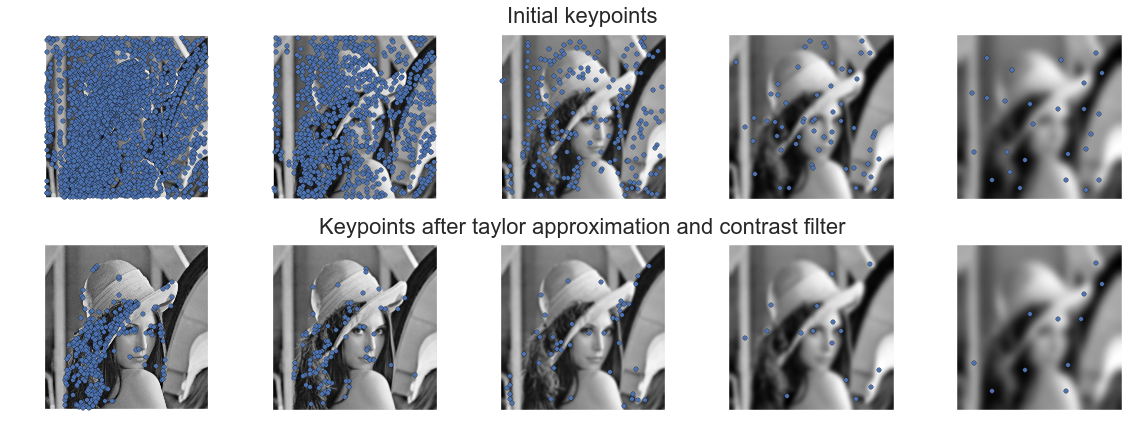

In [154]:
lena = load_lena()
num_octaves = 5
sift = SIFT(lena, num_octaves)

fig, axes = plt.subplots(2, num_octaves, figsize=(16, 6))
fig.tight_layout()

acc_keypoints_pyr = []
keypoints_pyr = sift.get_inital_keypoints()
for i, keypoints in enumerate(keypoints_pyr):
    acc_keypoints = sift.get_accurate_keypoints(keypoints, i)
    acc_keypoints_pyr.append(acc_keypoints)
    axes[0, i].imshow(sift.scaled_images[i], cmap='gray')
    axes[1, i].imshow(sift.scaled_images[i], cmap='gray')
    axes[0, i].scatter(keypoints[:, 2], keypoints[:, 1])
    axes[1, i].scatter(acc_keypoints[:, 2], acc_keypoints[:, 1])
    axes[0, i].axis('off')
    axes[1, i].axis('off')
    
axes[0, num_octaves // 2].set_title("Initial keypoints", fontsize=22)
_ = axes[1, num_octaves // 2].set_title("Keypoints after taylor approximation and contrast filter", fontsize=22)

In [155]:
def print_num_keypoints(keypoints_pyr):
    num_keypoints_pyr = list(map(len, keypoints_pyr))
    print(num_keypoints_pyr)
    print(sum(num_keypoints_pyr))
    
print_num_keypoints(keypoints_pyr)
print_num_keypoints(acc_keypoints_pyr)

[3536, 1082, 235, 59, 26]
4938
[425, 95, 46, 16, 11]
593


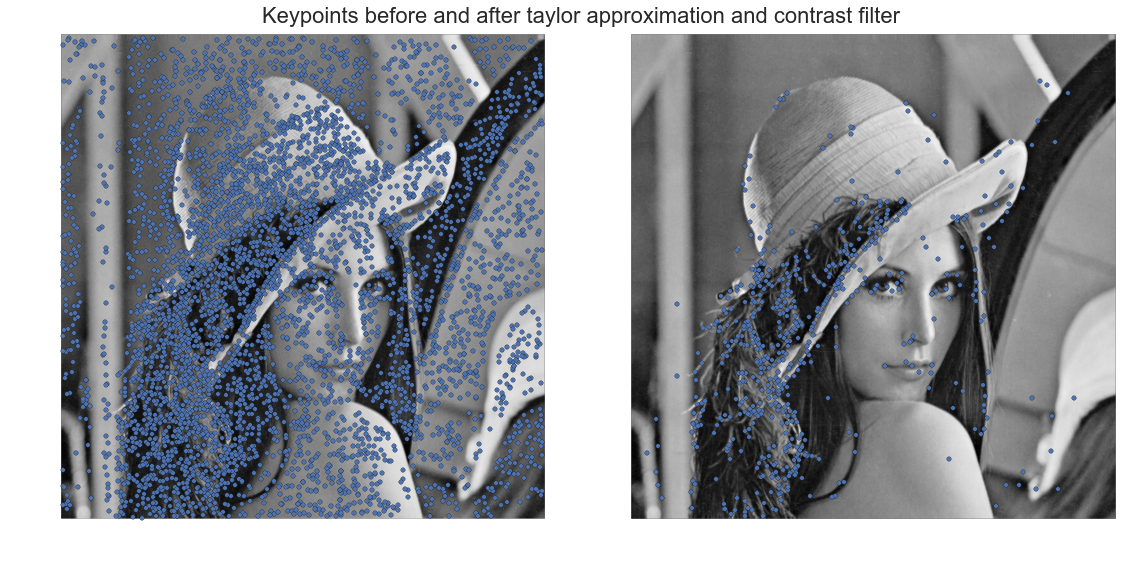

In [156]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.tight_layout()
fig.suptitle('Keypoints before and after taylor approximation and contrast filter', fontsize=22)

axes[0].imshow(lena, cmap='gray')
axes[1].imshow(lena, cmap='gray')

def scale_points(points, s):
    return points * (2 ** s)

for s, (keypoints, acc_keypoints)  in enumerate(zip(keypoints_pyr, acc_keypoints_pyr)):
    keypoints_scaled = scale_points(keypoints, s)
    acc_keypoints_scaled = scale_points(acc_keypoints, s)
    axes[0].scatter(keypoints_scaled[:, 2], keypoints_scaled[:, 1])
    axes[1].scatter(acc_keypoints_scaled[:, 2], acc_keypoints_scaled[:, 1])
    axes[0].axis('off')
    axes[1].axis('off')

[425, 95, 46, 16, 11]
593
[413, 92, 46, 16, 11]
578


(-51.700000000000003, 1074.7, 1074.7, -51.700000000000003)

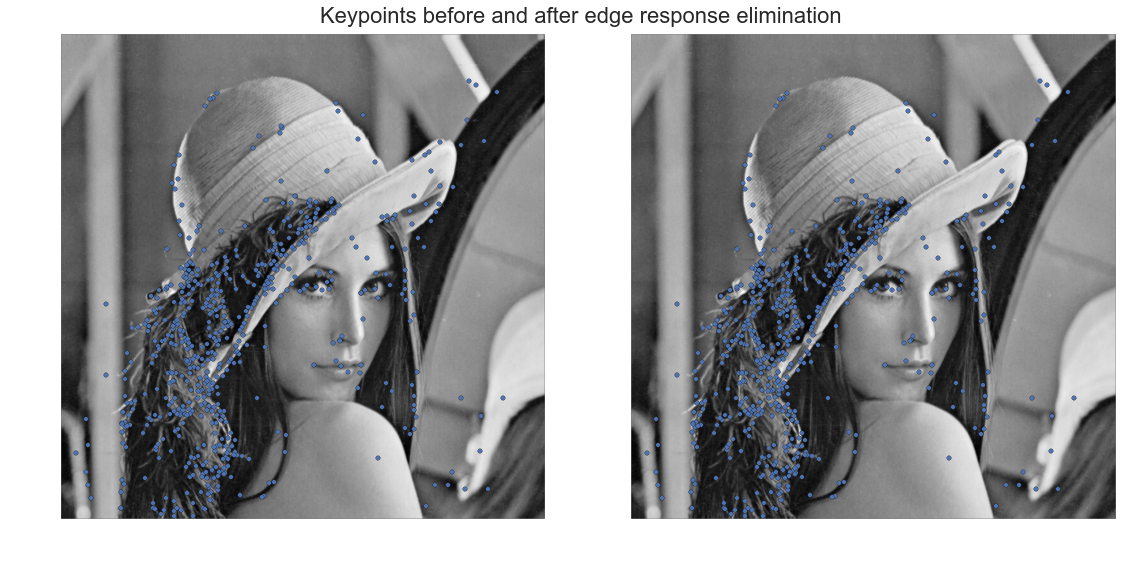

In [157]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.tight_layout()
fig.suptitle('Keypoints before and after edge response elimination', fontsize=22)

axes[0].imshow(lena, cmap='gray')
axes[1].imshow(lena, cmap='gray')

def scale_points(points, s):
    return points * (2 ** s)

filtered_keypoints_pyr = sift.eliminate_edge_responses(acc_keypoints_pyr)
print_num_keypoints(acc_keypoints_pyr)
print_num_keypoints(filtered_keypoints_pyr)

for s, (keypoints, filtered_keypoints)  in enumerate(zip(acc_keypoints_pyr, filtered_keypoints_pyr)):
    keypoints_scaled = scale_points(keypoints, s)
    filtered_keypoints_scaled = scale_points(filtered_keypoints, s)
    axes[0].scatter(keypoints_scaled[:, 2], keypoints_scaled[:, 1])
    axes[1].scatter(filtered_keypoints_scaled[:, 2], filtered_keypoints_scaled[:, 1])
axes[0].axis('off')
axes[1].axis('off')

In [205]:
def assign_orientations(keypoint_pyr, num_bins=36):
    image_derivatives = []
    for image in sift.scaled_images:
        image_derivatives.append(np.array((scharr_h(image), scharr_v(image))))
        
    def get_window_center(slicex, slicey, point):
        def get_center(sl, point):
            return np.argmin(np.abs(np.array(range(sl.start, sl.stop)) - point))
        return get_center(slicex, point[1]), get_center(slicey, point[2])
    
    oriented_keypoint_pyr = []
    orientation_pyr = []
    for pyramid_level, (keypoints, image) in enumerate(zip(keypoint_pyr, image_derivatives)):
        oriented_keypoints = []
        orientations = []
        for point in keypoints:
            sigma = 1.5 * get_sigma(point[0])
            wsize = int(sigma * 3 / 2)
            
            sx = slice(max(0, point[1] - wsize), min(image.shape[1], point[1] + wsize + 1))
            sy = slice(max(0, point[2] - wsize), min(image.shape[2], point[2] + wsize + 1))
            
            gradx = image[0, sx, sy]
            grady = image[1, sx, sy]
            
            centerx, centery = get_window_center(sx, sy, point)
            
            gradient = np.sqrt(gradx**2 + grady**2)
            theta = np.arctan2(grady, gradx)
            
            gaussianx = scipy.stats.norm(point[1], sigma).pdf(range(sx.start, sx.stop))
            gaussiany = scipy.stats.norm(point[2], sigma).pdf(range(sy.start, sy.stop))
            gaussian = gaussianx[:, np.newaxis] @ gaussiany[:, np.newaxis].T            
            
            bins, _ = np.histogram(theta, weights=gaussian * gradient, bins=num_bins, range=(-np.pi, np.pi))
            
            highest_peak = max(bins)
            indices = np.nonzero(bins >= 0.8 * highest_peak)[0]
            
            for idx in indices:
                x = np.array(range(idx-1, idx+2))
                y = bins[x % num_bins]              
                coeffs = np.polyfit(x, y, deg=2)
                parabola_fit = -coeffs[1] / (2 * coeffs[0])
                
                oriented_keypoints.append(point)
                orientations.append((parabola_fit - 0.5 * num_bins) / (0.5 * num_bins) * np.pi)
            
        oriented_keypoint_pyr.append(np.array(oriented_keypoints))
        orientation_pyr.append(np.array(orientations))
    return oriented_keypoint_pyr, orientation_pyr

In [206]:
oriented_keypoint_pyr, orientation_pyr = assign_orientations(filtered_keypoints_pyr)

(-51.700000000000003, 1074.7, 1074.7, -51.700000000000003)

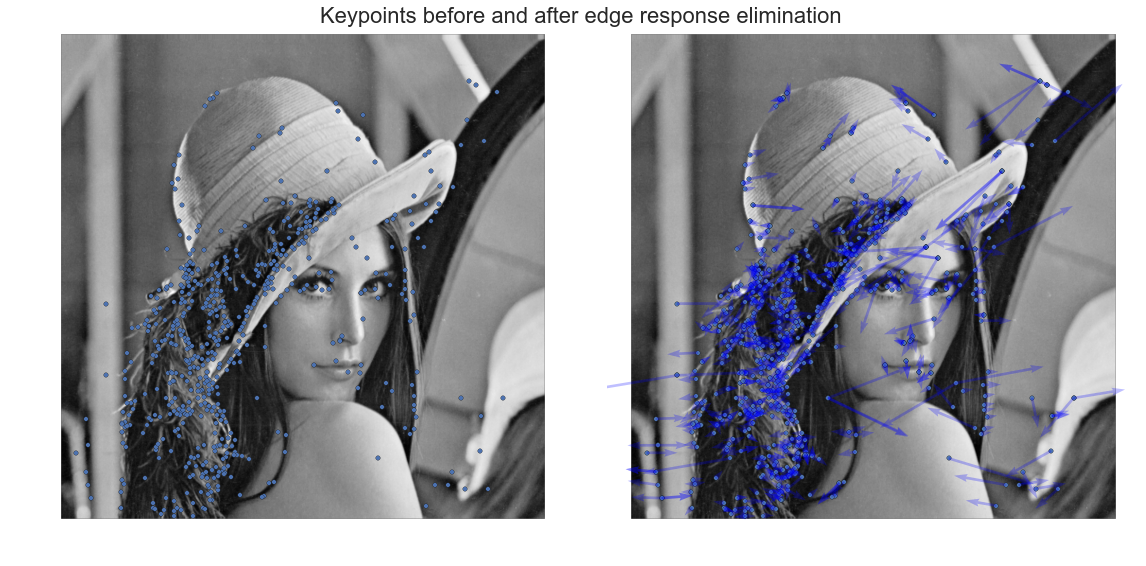

In [160]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.tight_layout()
fig.suptitle('Keypoints before and after edge response elimination', fontsize=22)

axes[0].imshow(lena, cmap='gray')
axes[1].imshow(lena, cmap='gray')

def scale_points(points, s):
    if points.shape[1] == 3:
        return points * (2 ** s)
    return points[:, :3] * (2 ** s), points[:, 3]

for s, (filtered_keypoints, oriented_keypoints)  in enumerate(zip(filtered_keypoints_pyr, oriented_keypoints_pyr)):
    filtered_keypoints_scaled = scale_points(filtered_keypoints, s)
    oriented_keypoints_scaled, oriented_thetas = scale_points(oriented_keypoints, s)
    
    axes[0].scatter(filtered_keypoints_scaled[:, 2], filtered_keypoints_scaled[:, 1])
    axes[1].scatter(oriented_keypoints_scaled[:, 2], oriented_keypoints_scaled[:, 1])
    
    axes[1].quiver(oriented_keypoints_scaled[:, 2], oriented_keypoints_scaled[:, 1],
                   np.sin(oriented_thetas) * 1.7**s, np.cos(oriented_thetas) * 1.7**s, 
                   width=0.005, scale=50, color='blue', alpha=0.25)
    
axes[0].axis('off')
axes[1].axis('off')

In [228]:
def get_descriptors(keypoint_pyr, orientation_pyr, num_bins=8, wsize=16//2, dsize=4):
    # TODO: should be a class member
    image_derivatives = []
    for image in sift.scaled_images:
        image_derivatives.append(np.array((scharr_h(image), scharr_v(image))))
        
    def in_bounds(p, image):
        try:
            image[:, p[0], p[1]]
            if np.min(point) >= 0:
                return True
            return False
        except IndexError:
            return False
        
    gaussianx = scipy.stats.norm(0, wsize).pdf(range(-wsize, wsize + 1))
    gaussiany = scipy.stats.norm(0, wsize).pdf(range(-wsize, wsize + 1))
    gaussian = gaussianx[:, np.newaxis] @ gaussiany[:, np.newaxis].T
    
    descriptor_pyr = []
    for pyramid_level, (keypoints, orients, image) in enumerate(zip(keypoint_pyr, orientation_pyr, image_derivatives)):
        descriptors = []
        for point, point_orientation in zip(keypoints, orients):
            rwsize = int(np.ceil(wsize * np.sqrt(2)))
            sx = slice(point[1] - rwsize, point[1] + rwsize + 1)
            sy = slice(point[2] - rwsize, point[2] + rwsize + 1)
            
            if np.any([not(in_bounds(p, image)) for p in ((sx.start, sy.start), (sx.stop - 1, sy.stop - 1))]):
                continue
                
            print('yep')
            
            gradx = rotate(image[0, sx, sy], -point_orientation)
            grady = rotate(image[1, sx, sy], -point_orientation)
            
            print(image[0, sx, sy].shape)
            print(gradx.shape)
            assert(gradx.shape == (wsize * 2, wsize * 2))
            
            gradx = gradx * gaussian
            grady = grady * gaussian
            
            magnitude = np.sqrt(gradx**2 + grady**2)
            theta = np.arctan2(grady, gradx)
                        
            descriptors = []
            for fromx in np.arange(0, wsize*2+1, dsize):
                for fromy in np.arange(0, wsize*2+1, dsize):
                    sx = slice(fromx, fromx+dsize+1)
                    sy = slice(fromy, fromy+dsize+1)
                    window_magnitude = magnitude[sx, sy]
                    window_theta = theta[sx, sy]
                    
                    bins, _ = np.histogram(window_theta, weights=window_magnitude, 
                                           bins=num_bins, range=(-np.pi, np.pi))
                    descriptors.append(bins)
            descriptors = np.array(descriptors)
        descriptor_pyr.append(np.array(descriptors))
    return descriptor_pyr

In [229]:
descriptor_pyr = get_descriptors(oriented_keypoint_pyr, orientation_pyr)

yep
(25, 25)
(25, 25)


AssertionError: 

In [192]:
descriptor_pyr

[array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64)]

In [178]:
x = np.arange(0, 9, 4)
#y = np.arange(-5, 5, 0.1)
xx = np.meshgrid(x, x, sparse=True)
x

array([0, 4, 8])

In [180]:
xx

[array([[0, 4, 8]]), array([[0],
        [4],
        [8]])]

In [169]:
yy

array([[0],
       [4]])